In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
import networkx as nx
import matplotlib.pyplot as plt
import itertools

In [4]:
df = pd.read_csv("hessle_with_features.csv")

df['styles'] = df['styles'].str.split(', ')

genre_correction = {
    'break beat' : 'breakbeat', #no distinction
    "abstract" : "experimental", #going out on a limb that they're being used analogously
    "Garage House" : "UK Garage", #given it is a uk label and 'Garage House' is typically used to refer to music in reference to the paradise garage (NJ)
    "Minimal" : "Dub Techno" #not totally sure this is a correct conflation, just curious about how it fx the networkmap
}

df['styles'] = df['styles'].apply(lambda genres: [genre_correction.get(genre, genre) for genre in genres])

In [7]:
def calculate_weights(genres):
    weight_per_genre = 1 / len(genres)
    return {genre: weight_per_genre for genre in genres}
    
# split up the styles sections

df['genre_weights'] = df['styles'].apply(calculate_weights)

df_exploded_no_weight = df.explode('styles')

for feature in ['tempo', 'centroid_mean', 'spread_mean', 'rolloff_mean']:
    df_exploded[feature] = df_exploded_no_weight.apply(lambda row: row[feature] * row['genre_weights'][row['styles']], axis=1)


NameError: name 'df_exploded' is not defined

In [6]:
genre_counts = df_exploded['styles'].value_counts()

# Normalize these counts
genre_counts_normalized = genre_counts / genre_counts.sum()

for genre in genre_counts_normalized.keys():
    similarity_df[genre] = similarity_df[genre].apply(lambda x: x / genre_counts_normalized[genre])
genre_counts.plot(kind='bar', figsize=(15, 8))
plt.title('Genre Frequencies')
plt.ylabel('Frequency')
plt.xlabel('Genre')
plt.show()

NameError: name 'df_exploded' is not defined

Number of unique styles: 16
Dimensions of the similarity matrix: (16, 16)


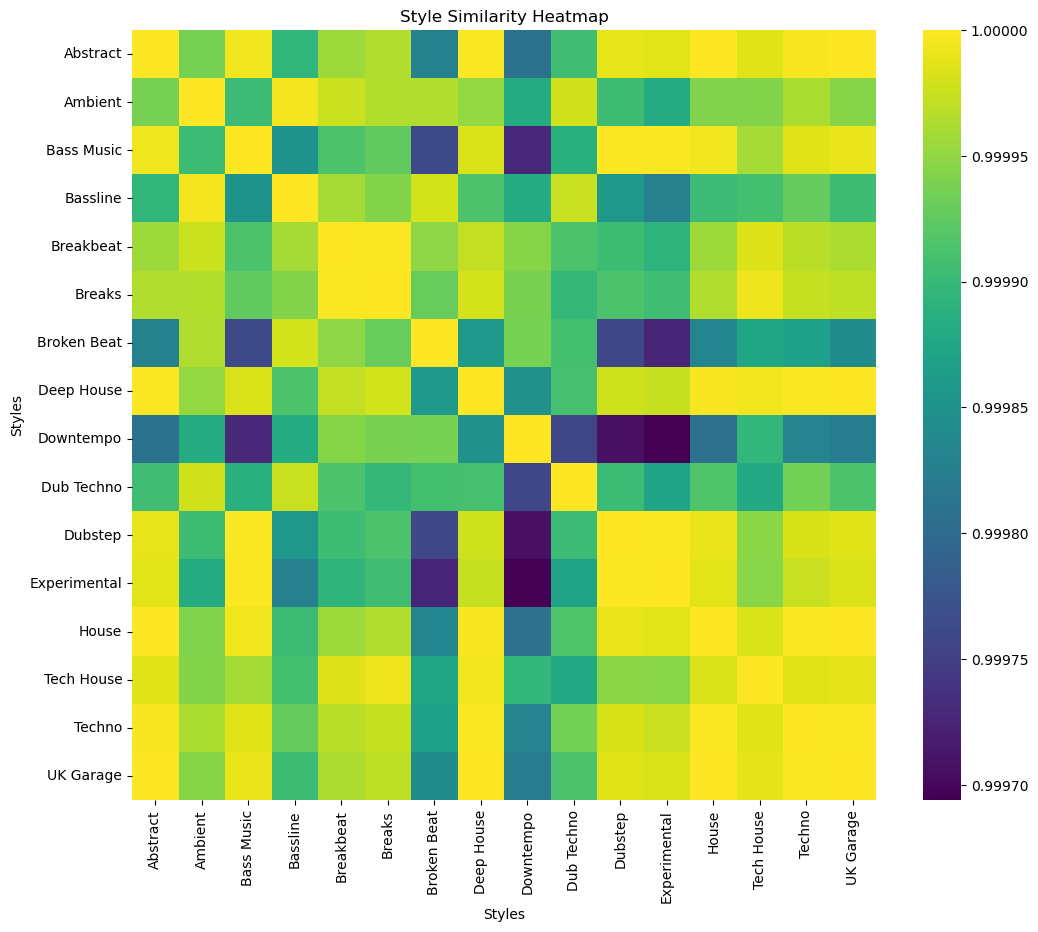

In [167]:
encoder = OneHotEncoder()
styles_encoded = encoder.fit_transform(df_exploded_no_weight[['styles']]).toarray()
style_means = df_exploded_no_weight.groupby('styles')[['tempo', 'centroid_mean', 'spread_mean', 'rolloff_mean']].mean()
# Compute the similarity matrix
similarity_matrix = cosine_similarity(style_means)

# style_names = encoder.categories_[0]


print(f"Number of unique styles: {len(style_names)}")
print(f"Dimensions of the similarity matrix: {similarity_matrix.shape}")

similarity_df = pd.DataFrame(similarity_matrix, index=style_means.index, columns=style_means.index)

plt.figure(figsize=(12, 10))
sns.heatmap(similarity_df, annot=False, cmap="viridis")
plt.title('Style Similarity Heatmap')
plt.xlabel('Styles')
plt.ylabel('Styles')
plt.show()

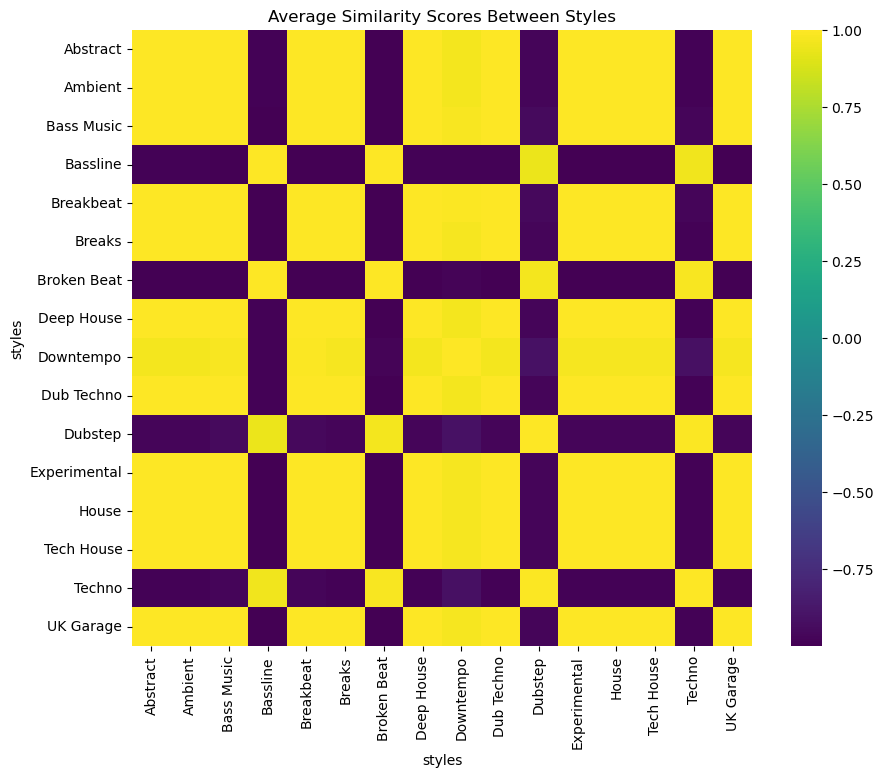

In [171]:
## at one point this was interesting but atm it's just like yellow or dark blue.

# import pandas as pd
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics.pairwise import cosine_similarity
# import seaborn as sns
# import matplotlib.pyplot as plt

# # split up the styles sections

# for feature in ['tempo', 'centroid_mean', 'spread_mean', 'rolloff_mean']:
#     df_exploded[feature] = df_exploded.apply(lambda row: row[feature] * row['genre_weights'][row['styles']], axis=1)

# # Group by styles and calculate the mean of features
# style_means = df_exploded.groupby('styles')[['tempo', 'centroid_mean', 'spread_mean', 'rolloff_mean']].mean()

# # Normalize these averages
# scaler = StandardScaler()
# scaled_style_means = scaler.fit_transform(style_means)

# # Step 2: Calculate Similarity
# similarity_matrix = cosine_similarity(scaled_style_means)

# # Convert to DataFrame for easier handling
# similarity_df = pd.DataFrame(similarity_matrix, index=style_means.index, columns=style_means.index)

# # Step 3: Plot the Heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(similarity_df, annot=False, cmap="viridis")
# plt.title('Average Similarity Scores Between Styles')
# plt.show()


In [ ]:
# grouped = df_exploded.groupby('styles')[['tempo', 'centroid_mean', 'spread_mean', 'rolloff_mean']].mean()

# # Adjust the similarity scores based on genre frequency
# for genre in genre_counts_normalized.keys():
#     similarity_df[genre] = similarity_df[genre].apply(lambda x: x / genre_counts_normalized[genre])

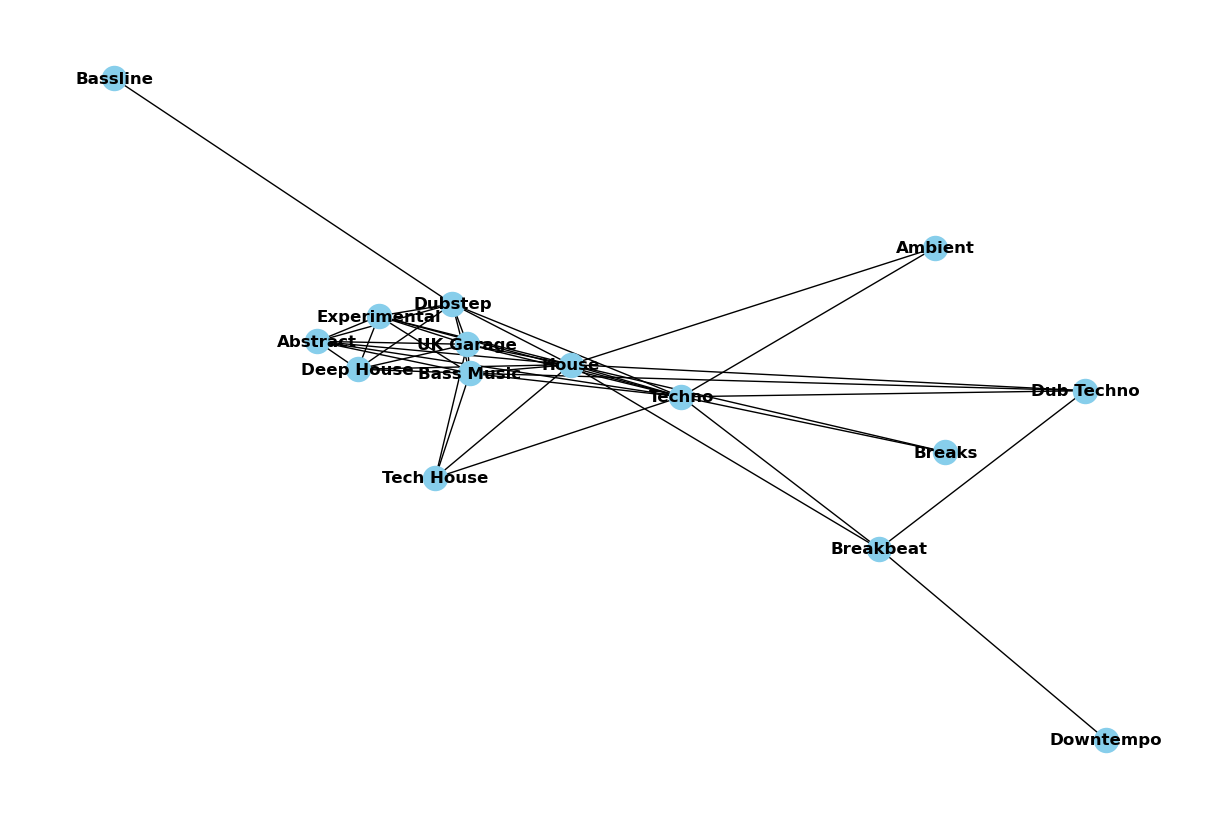

In [8]:
#i'm not totally sure what order/df to do this on
#i've been jumping around a lot so it changes depending on what cell i've executed
G = nx.Graph()

# Add nodes and edges
for genres in df['styles']:
    for genre in genres:
        if genre not in G:
            G.add_node(genre)
    for genre_pair in itertools.combinations(genres, 2):
        if G.has_edge(*genre_pair):
            G[genre_pair[0]][genre_pair[1]]['weight'] += 1
        else:
            G.add_edge(*genre_pair, weight=1)

outlier_genre = 'Broken Beat'  # poor broken beat, as always an outlier
if outlier_genre in G:
    G.remove_node(outlier_genre)

# broken beat is way far out which kinda makes sense for the label, 
# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(G, with_labels=True, font_weight='bold', node_color='skyblue')
plt.show()

In [138]:
encoder = OneHotEncoder()
styles_encoded = encoder.fit_transform(df_exploded[['styles']]).toarray()

# Compute the similarity matrix
similarity_matrix = cosine_similarity(styles_encoded)

# Convert to DataFrame for easier handling
style_names = encoder.categories_[0]
similarity_df = pd.DataFrame(similarity_matrix, index=style_names, columns=style_names)

ValueError: Shape of passed values is (167, 167), indices imply (1, 1)

In [61]:
from sklearn.metrics import jaccard_score
binary_matrix = pd.get_dummies(df_exploded['styles']).groupby(level=0).max()

# Calculate Jaccard similarity
jaccard_similarities = pd.DataFrame(index=binary_matrix.index, columns=binary_matrix.index)

for pair in itertools.combinations(binary_matrix.index, 2):
    sim = jaccard_score(binary_matrix.loc[pair[0]], binary_matrix.loc[pair[1]])
    jaccard_similarities.at[pair[0], pair[1]] = sim
    jaccard_similarities.at[pair[1], pair[0]] = sim

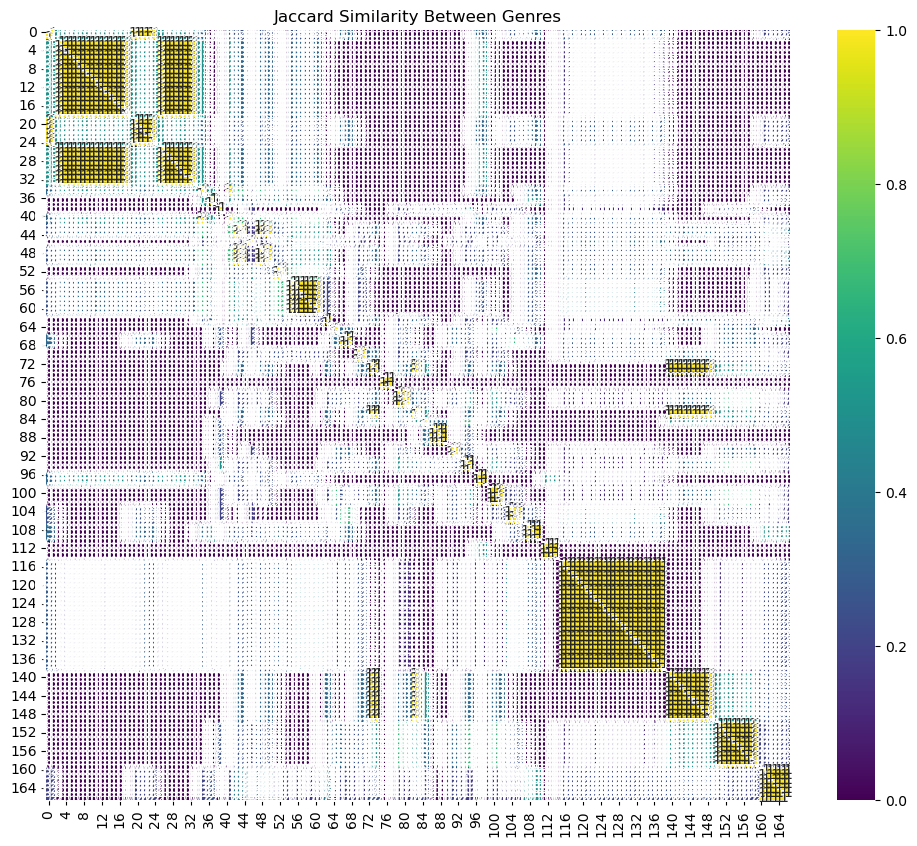

In [74]:
# this would maybe be interesting if I had a better idea of what was being done, so I had a clue what was being shown
# and thus why it isn't implemented quite right (i think, or maybe it's not a great metric for the task at hand)
# i think the numbers represent individual tracks in the df judging by the range going a bit past 160
jaccard_similarities = jaccard_similarities.astype(float)

# Plotting
plt.figure(figsize=(12, 10))
sns.heatmap(jaccard_similarities, annot=True, cmap='viridis')
plt.title('Jaccard Similarity Between Genres')
plt.show()

/home/ekstasis/.local/lib/python3.8/site-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/home/ekstasis/.local/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


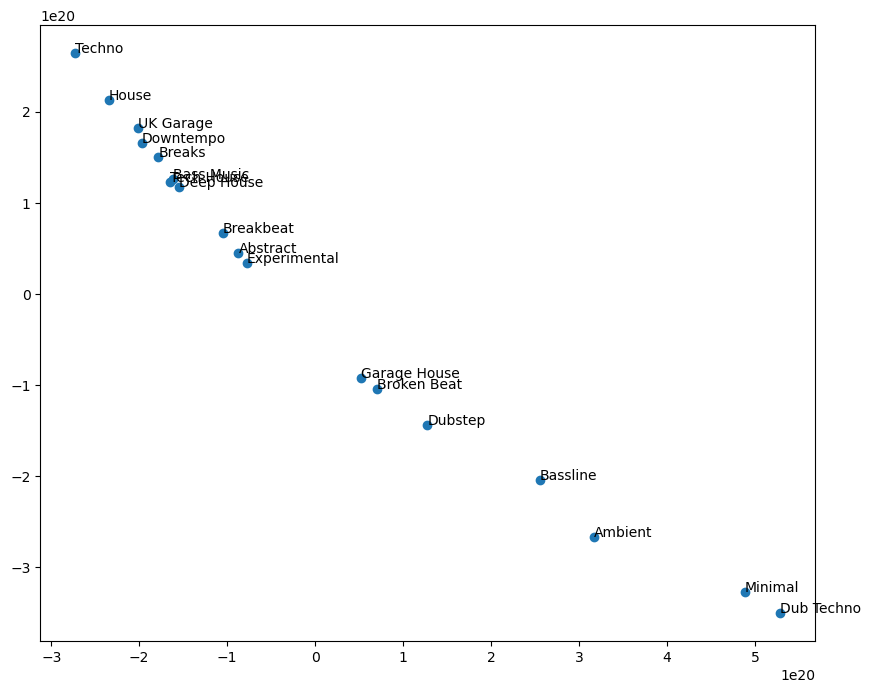

In [124]:
from sklearn.manifold import MDS

mds2d = MDS(n_components=2)

# Fit and transform the data
mds_result = mds.fit_transform(similarity_df)

# Plot the results
plt.figure(figsize=(10, 8))
plt.scatter(mds_result[:, 0], mds_result[:, 1])
for i, genre in enumerate(similarity_df.index):
    plt.text(mds_result[i, 0], mds_result[i, 1], genre)
plt.show()

In [130]:
max_sim = np.max(similarity_df.values)
dissim_mtx = max_sim - similarity_df #get distance
dissim_mtx = (dissim_mtx + dissim_mtx.T)/2

mds3d = MDS(n_components=3, random_state=42, dissimilarity="precomputed")

# Perform MDS
mds3d_result = mds3d.fit_transform(dissim_mtx)

/home/ekstasis/.local/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


ValueError: 'c' argument has 458 elements, which is inconsistent with 'x' and 'y' with size 18.

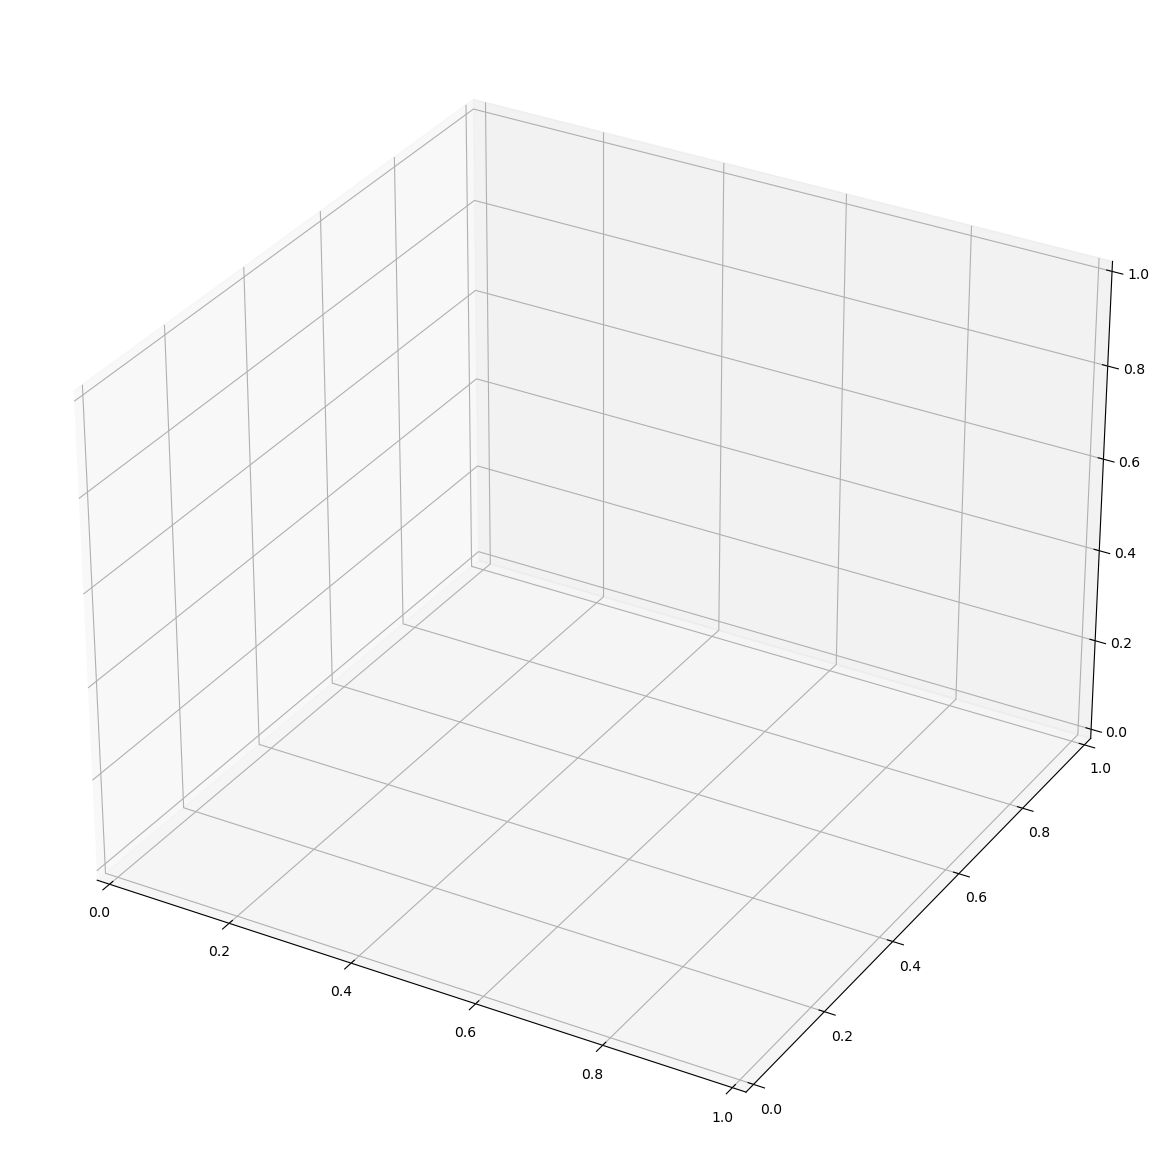

In [173]:
from mpl_toolkits.mplot3d import Axes3D

categories = pd.Categorical(df_exploded['styles'])
colors = categories.codes
# Create a 3D plot
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for the MDS results
x_values = mds3d_result[:, 0]
y_values = mds3d_result[:, 1]
z_values = mds3d_result[:, 2]

ax.scatter(x_values, y_values, z_values, c=colors)

# Labeling axes
ax.set_xlabel('MDS1')
ax.set_ylabel('MDS2')
ax.set_zlabel('MDS3')

# Title
plt.title('3D MDS Visualization')

plt.show()

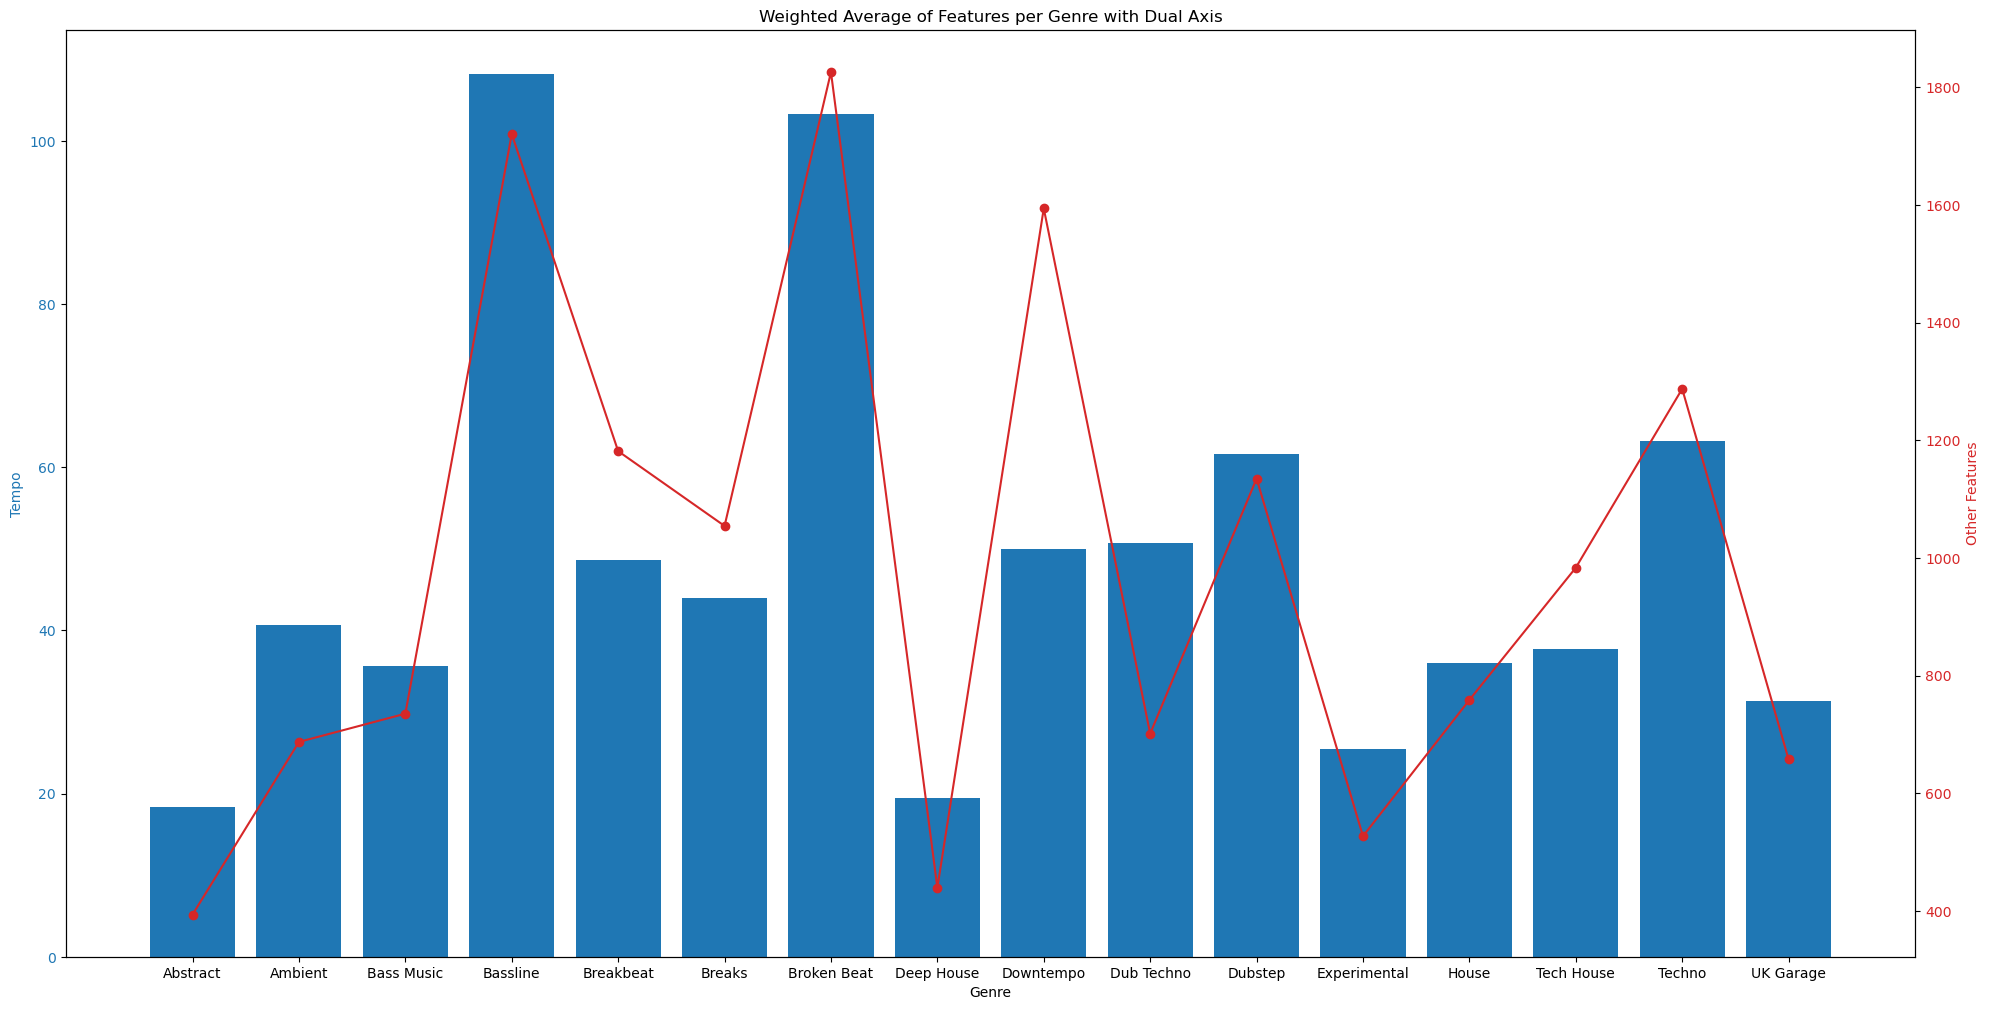

In [174]:
## i need to re-evaluate tempo, granted there is a good amount of dubstep which one could easily hear as 70 bpm, most house/techno falls
# between 110 on the very slow side to 140+ high side. Also most dubstep producers would probably tell you they hear/program the music
# at 140 bpm with halftime sensibility

fig, ax1 = plt.subplots(figsize=(20, 10))

# Assuming 'grouped' is your DataFrame after applying weights
# Plot the 'tempo' on the first axis
color = 'tab:blue'
ax1.set_xlabel('Genre')
ax1.set_ylabel('Tempo', color=color)
ax1.bar(grouped.index, grouped['tempo'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second axis for other features
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Other Features', color=color)
# Assuming other features are averaged and stored in 'other_features'
other_features = grouped[['centroid_mean', 'spread_mean', 'rolloff_mean']].mean(axis=1)
ax2.plot(grouped.index, other_features, color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Weighted Average of Features per Genre with Dual Axis')
plt.show()

/home/ekstasis/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/ekstasis/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


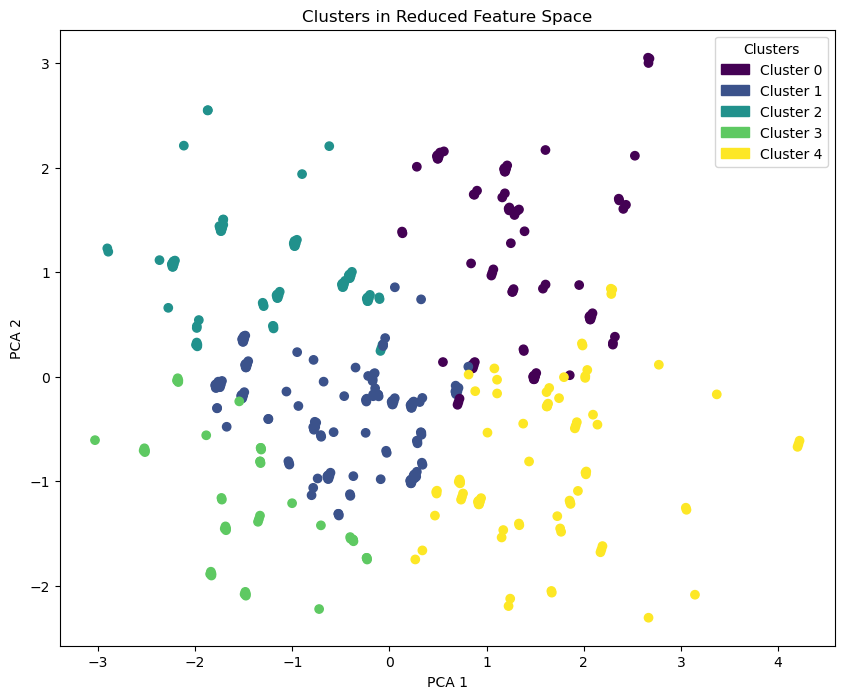

In [31]:

df['styles'] = df['styles'].str.split(', ')
df = df.explode('styles')

# One-hot encode 'styles'
one_hot_encoder = OneHotEncoder(sparse=False)
styles_encoded = one_hot_encoder.fit_transform(df[['styles']])

# Select and scale features
features = df[['tempo', 'centroid_mean', 'spread_mean', 'rolloff_mean' ]]  # include desired features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Combine scaled features with encoded styles
import numpy as np
X = np.concatenate([scaled_features, styles_encoded], axis=1)

# Clustering
kmeans = KMeans(n_clusters=5)  # adjust number of clusters
clusters = kmeans.fit_predict(X)

# Add cluster labels to the DataFrame
df['cluster'] = clusters

# PCA for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(X)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis')

# Create a legend
# We get the unique labels from the clusters
unique_labels = np.unique(clusters)
# Create a patch (proxy artist) for each cluster
patches = [mpatches.Patch(color=scatter.cmap(scatter.norm(label)), label=f'Cluster {label}') for label in unique_labels]
# Add the legend to the plot
plt.legend(handles=patches, title='Clusters')

# Add labels and title
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Clusters in Reduced Feature Space')
plt.show()

/home/ekstasis/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/ekstasis/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


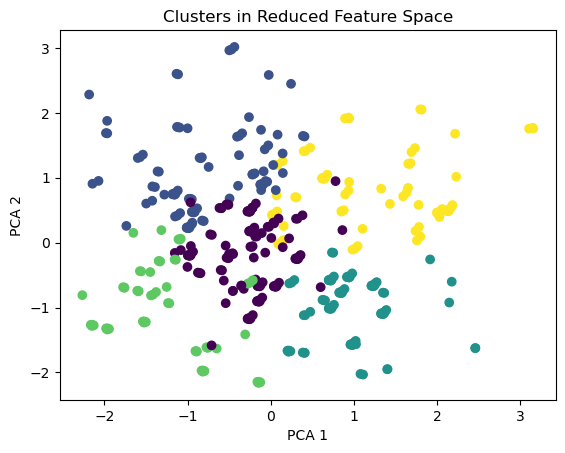

In [26]:
# Assuming df is your DataFrame
# Preprocess 'styles'
df['styles'] = df['styles'].str.split(', ')
df = df.explode('styles')

# One-hot encode 'styles'
one_hot_encoder = OneHotEncoder(sparse=False)
styles_encoded = one_hot_encoder.fit_transform(df[['styles']])

# Select and scale features
features = df[['tempo', "spread_mean", 'rolloff_mean' ]]  # include desired features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Combine scaled features with encoded styles
import numpy as np
X = np.concatenate([scaled_features, styles_encoded], axis=1)

# Clustering
kmeans = KMeans(n_clusters=5)  # adjust number of clusters
clusters = kmeans.fit_predict(X)

# Add cluster labels to the DataFrame
df['cluster'] = clusters

# PCA for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(X)

# Plotting
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Clusters in Reduced Feature Space')
plt.show()

# Analyze the clusters
# This part depends on your specific questions and analysis needs

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt


In [135]:
# Relate to styles
df['styles'] = df['styles'].str.split(', ')
df_exploded = df.explode('styles')

# Select and scale features
features = df_exploded[['tempo', 'centroid_mean', 'centroid_std']]  # include desired features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Compute similarity matrix
similarity_matrix = cosine_similarity(scaled_features)

# Convert to DataFrame for easier handling
similarity_df = pd.DataFrame(similarity_matrix, index=df_exploded.index, columns=df_exploded.index)

# Calculate average similarity per style
def avg_similarity(group):
    indices = group.index
    return similarity_df.loc[indices, indices].mean().mean()

average_similarity = df_exploded.groupby('styles').apply(avg_similarity)

# Reshape the similarity data
average_similarity_matrix = average_similarity.unstack().fillna(0)

# Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(average_similarity_matrix, annot=True, fmt=".2f")
plt.title('Average Similarity Scores Between Styles')
plt.show()

IndexError: Inconsistent shape between the condition and the input (got (0, 1) and (0,))

<Figure size 1000x800 with 0 Axes>

In [136]:
def avg_similarity(group):
    indices = group.index
    return similarity_df.loc[indices, indices].mean().mean()

average_similarity = df_exploded.groupby('styles').apply(avg_similarity)

# Ensure it's in matrix form
average_similarity_matrix = average_similarity.unstack().fillna(0)

# Inspecting the DataFrame
print(average_similarity_matrix.shape)
print(average_similarity_matrix.head())

# Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(average_similarity_matrix, annot=True, fmt=".2f", cmap="viridis")
plt.title('Average Similarity Scores Between Styles')
plt.show()

(0,)
Series([], dtype: float64)


IndexError: Inconsistent shape between the condition and the input (got (0, 1) and (0,))

<Figure size 1000x800 with 0 Axes>

In [40]:
from itertools import combinations
import collections

In [42]:
# Calculate co-occurrence of styles
co_occurrence = collections.Counter()
for styles in df['styles']:
    for style_pair in combinations(set(styles), 2):
        co_occurrence[style_pair] += 1

for styles in df['styles']:
    for style_tri

# Convert to DataFrame for easier visualization
co_occurrence_df = pd.Series(co_occurrence).reset_index()
co_occurrence_df.columns = ['Style 1', 'Style 2', 'Co-occurrence Count']

# Sort the DataFrame for better readability
co_occurrence_df.sort_values(by='Co-occurrence Count', ascending=False, inplace=True)

# Display the top co-occurrences
co_occurrence_df

,Style 1,Style 2,Co-occurrence Count
0,Dubstep,Experimental,32
2,Dubstep,UK Garage,32
3,Dubstep,Bass Music,32
11,House,UK Garage,28
13,House,Deep House,28
10,Experimental,Abstract,27
12,House,Bass Music,26
14,House,Abstract,24
1,Dubstep,House,24
20,Deep House,Abstract,24
